# GBDT

#### Response Coding: Example

<img src='http://i.imgur.com/TufZptV.jpg' width=700px>

> The response tabel is built only on train dataset.
> For a category which is not there in train data and present in test data, we will encode them with default values
Ex: in our test data if have State: D then we encode it as [0.5, 0.05]

<ol>
    <li><strong>Apply GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)+sentiment Score of eassay(check the bellow example, include all 4 values as 4 features)</li>
            <li><font color='red'>Set 2</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V)</li>        </ul>
    </li>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation/simple cross validation data</li>
    <li>use gridsearch cv or randomsearch cv or you can write your own for loops to do this task</li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
            </ul>
    <br>
    
</ol>

<h1>1. GBDT (xgboost/lightgbm) </h1>

## 1.0 Import necessary packages & Loading Data

<h2>1.1 GBDT with TFIDF W2V and response coding with categorical features</h2>

In [ ]:
#https://www.kaggle.com/c/donorschoose-application-screening/notebooks
#https://xgboost.readthedocs.io/en/latest/parameter.html
#https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

import pickle
from tqdm import tqdm
import os

#from plotly import plotly
#import plotly.offline as offline
#import plotly.graph_objs as go
#offline.init_notebook_mode()
from collections import Counter

In [ ]:
project_df = pd.read_csv('preprocessed_data.csv', nrows = 30000)
project_df.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [ ]:
project_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 9 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   school_state                                  30000 non-null  object 
 1   teacher_prefix                                30000 non-null  object 
 2   project_grade_category                        30000 non-null  object 
 3   teacher_number_of_previously_posted_projects  30000 non-null  int64  
 4   project_is_approved                           30000 non-null  int64  
 5   clean_categories                              30000 non-null  object 
 6   clean_subcategories                           30000 non-null  object 
 7   essay                                         30000 non-null  object 
 8   price                                         30000 non-null  float64
dtypes: float64(1), int64(2), object(6)
memory usage: 2.1+ MB


In [ ]:
project_df['project_is_approved'].value_counts()

1    25373
0     4627
Name: project_is_approved, dtype: int64

<h2>1.2 Getting sentiment score beased on essay features and concat with original dataframe</h2>

In [ ]:
essay = project_df['essay'].to_list()
print(essay[1])

imagine 8 9 years old you third grade classroom you see bright lights kid next chewing gum birds making noise street outside buzzing cars hot teacher asking focus learning ack you need break so students most students autism anxiety another disability it tough focus school due sensory overload emotions my students lot deal school i think makes incredible kids planet they kind caring sympathetic they know like overwhelmed understand someone else struggling they open minded compassionate they kids someday change world it tough one thing time when sensory overload gets way hardest thing world focus learning my students need many breaks throughout day one best items used boogie board if classroom students could take break exactly need one regardless rooms school occupied many students need something hands order focus task hand putty give sensory input need order focus calm overloaded help improve motor skills make school fun when students able calm ready learn when able focus learn retain t

In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
def nltk_sentiment(sentence):
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    
    nltk_sentiment = SentimentIntensityAnalyzer()
    score = nltk_sentiment.polarity_scores(sentence)
    return score

In [ ]:
from tqdm import tqdm
nltk_results = [nltk_sentiment(row) for row in tqdm(essay)]

100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [06:52<00:00, 72.68it/s]


In [ ]:
essay_df = pd.DataFrame(nltk_results)
essay_df.head(2)

,neg,neu,pos,compound
0,0.013,0.783,0.205,0.9867
1,0.072,0.680,0.248,0.9897


In [ ]:
essay_df.shape

(30000, 4)

In [ ]:
final_project_df = pd.concat([project_df, essay_df], axis=1)
final_project_df.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,neg,neu,pos,compound
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05,0.013,0.783,0.205,0.9867
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03,0.072,0.680,0.248,0.9897
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00,0.017,0.721,0.262,0.9860
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04,0.030,0.783,0.187,0.9524
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74,0.029,0.683,0.288,0.9873


In [ ]:
y = final_project_df['project_is_approved'].values

<h2>1.3 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_project_df, y, test_size=0.33, stratify=y)

In [ ]:
X_train.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,neg,neu,pos,compound
5420,co,mrs,grades_prek_2,0,1,literacy_language history_civics,literature_writing socialsciences,i lucky teacher 24 wonderful students my stude...,291.87,0.039,0.633,0.328,0.9949
28407,in,mr,grades_6_8,0,0,health_sports,gym_fitness,8th graders exploding seams energy we great bu...,596.80,0.016,0.651,0.334,0.9945
12138,nj,mrs,grades_3_5,4,1,math_science,environmentalscience health_lifescience,every student deserves resources needed succee...,72.37,0.028,0.816,0.155,0.9413
14782,md,ms,grades_prek_2,16,1,literacy_language math_science,literature_writing mathematics,these upcoming 1st graders enthusiastic learne...,244.49,0.035,0.696,0.269,0.9879
6786,tx,mrs,grades_3_5,2,0,literacy_language,literature_writing,my school title i school best students planet ...,273.00,0.018,0.571,0.411,0.9963


<h2>1.4 Make Data Model Ready: encoding eassay with TFDF W2v and create numerical features without normalisation</h2>

In [ ]:
X1_train = X_train[['price', 'teacher_number_of_previously_posted_projects', 'neg', 'neu', 'pos', 'compound']]
X1_test = X_test[['price', 'teacher_number_of_previously_posted_projects', 'neg', 'neu', 'pos', 'compound']]

In [ ]:
x1_train = X1_train.to_numpy()
x1_test = X1_test.to_numpy()

In [ ]:
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [ ]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['essay'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)

print(len(tfidf_w2v_vectors))
print(len(tfidf_w2v_vectors[0]))
train_tfidf_w2v_vectors_essay = np.array(tfidf_w2v_vectors)
print(train_tfidf_w2v_vectors_essay.shape, y_train.shape)


100%|█████████████████████████████████████████████████████████████████████████| 20100/20100 [00:00<00:00, 25633.85it/s]

20100
300
(20100, 300) (20100,)


In [ ]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_test['essay'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)

print(len(tfidf_w2v_vectors))
print(len(tfidf_w2v_vectors[0]))
test_tfidf_w2v_vectors_essay = np.array(tfidf_w2v_vectors)
print(test_tfidf_w2v_vectors_essay.shape, y_test.shape)

100%|███████████████████████████████████████████████████████████████████████████| 9900/9900 [00:00<00:00, 25954.79it/s]

9900
300
(9900, 300) (9900,)


<h2>1.5 Make Data Model Ready: encoding categorical features with response coding</h2>

## Calculate Response Coding 

In [ ]:
# here I have used whole function from cancer diognise casestudy and understood it how it works 
# in response coding we get two probability output at each feature category
# for example, in this case we have feature called teacher prefix so we get two feature output for each category such as Mrs
# we can calculate by counting probabilty with respect to class label 

# first we creating function which takes parameter alpha which is laplace smoothing 1, fetaure (i.e teacher_prefix),
# and dataset which contain y_class label

def get_fea_dict(alpha, feature, df):
    
    value_count = df[feature].value_counts() #here we are counting total category of each feature
    
    
    fea_dict = dict() # here we creating dict
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items(): 
        
        vec = []
        for k in range(0,2): # here k takes two values 0 and 1 since we have two class label
            

            cls_cnt = df.loc[(df['project_is_approved']==k) & (df[feature]==i)] # here getting those values where fetaure 
            # category occur respect to class label (i.e project_approved = 1 & teacher_prefix = Mrs)
            # it will count for each feature category value
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha)/ (denominator + 2*alpha)) # here we are calculating probabilty value\
                                    # In denominator N + alpha * k here k is class label which is 2 in our case

        
        fea_dict[i]=vec
    return fea_dict

# Get feature values
def get_feature(alpha, feature, df):
    
    fea_dict = get_fea_dict(alpha, feature, df)
    # value_count is similar in get_fea_dict
    value_count = df[feature].value_counts()
    
    
    fea_value = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to fea_value
    # if not we will add [1/2,1/2] to fea_value
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            fea_value.append(fea_dict[row[feature]])
        else:
            fea_value.append([1/2,1/2])
            
    return fea_value

In [ ]:
alpha = 1
# train gene feature
train_data_schoolstate_feature_responseCoding = np.array(get_feature(alpha, "school_state", X_train))
test_data_schoolstate_feature_responseCoding = np.array(get_feature(alpha, "school_state", X_test))

print(train_data_schoolstate_feature_responseCoding.shape, y_train.shape)
print(test_data_schoolstate_feature_responseCoding.shape, y_test.shape)

(20100, 2) (20100,)
(9900, 2) (9900,)


In [ ]:
train_data_teacherprefix_feature_responseCoding = np.array(get_feature(alpha, "teacher_prefix", X_train))
test_data_teacherprefix_feature_responseCoding = np.array(get_feature(alpha, "teacher_prefix", X_test))

print(train_data_teacherprefix_feature_responseCoding.shape, y_train.shape)
print(test_data_teacherprefix_feature_responseCoding.shape, y_test.shape)

(20100, 2) (20100,)
(9900, 2) (9900,)


In [ ]:
train_data_gradcategory_feature_responseCoding = np.array(get_feature(alpha, "project_grade_category", X_train))
test_data_gradcategory_feature_responseCoding = np.array(get_feature(alpha, "project_grade_category", X_test))

print(train_data_gradcategory_feature_responseCoding.shape, y_train.shape)
print(test_data_gradcategory_feature_responseCoding.shape, y_test.shape)

(20100, 2) (20100,)
(9900, 2) (9900,)


In [ ]:
train_data_cleancategories_feature_responseCoding = np.array(get_feature(alpha, "clean_categories", X_train))
test_data_cleancategories_feature_responseCoding = np.array(get_feature(alpha, "clean_categories", X_test))

print(train_data_cleancategories_feature_responseCoding.shape, y_train.shape)
print(test_data_cleancategories_feature_responseCoding.shape, y_test.shape)

(20100, 2) (20100,)
(9900, 2) (9900,)


In [ ]:
train_data_cleansubcategories_feature_responseCoding = np.array(get_feature(alpha, "clean_subcategories", X_train))
test_data_cleansubcategories_feature_responseCoding = np.array(get_feature(alpha, "clean_subcategories", X_test))

print(train_data_cleansubcategories_feature_responseCoding.shape, y_train.shape)
print(test_data_cleansubcategories_feature_responseCoding.shape, y_test.shape)

(20100, 2) (20100,)
(9900, 2) (9900,)


In [ ]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr_1 = hstack((train_tfidf_w2v_vectors_essay, train_data_schoolstate_feature_responseCoding, train_data_teacherprefix_feature_responseCoding.shape, train_data_gradcategory_feature_responseCoding, train_data_cleancategories_feature_responseCoding, train_data_cleansubcategories_feature_responseCoding, X1_train)).tocsr()
X_te_1 = hstack((test_tfidf_w2v_vectors_essay, test_data_schoolstate_feature_responseCoding, test_data_teacherprefix_feature_responseCoding.shape, test_data_gradcategory_feature_responseCoding, test_data_cleancategories_feature_responseCoding, test_data_cleansubcategories_feature_responseCoding, X1_test)).tocsr()

print("Final Data matrix")
print(X_tr_1.shape, y_train.shape)
print(X_te_1.shape, y_test.shape)
print("="*100)

Final Data matrix
(20100, 316) (20100,)
(9900, 316) (9900,)


<h2>1.6 Building model with XGBooost implementation with GridSearchCV</h2>

#### Here I have tried scale_pose_weight parameter to balanced data 

In [ ]:
#https://machinelearningmastery.com/xgboost-for-imbalanced-classification/

counter = Counter(y)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 0.182


In [ ]:
# https://stackoverflow.com/questions/48377296/get-feature-importance-from-gridsearchcv
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
#https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/#:~:text=The%20number%20of%20trees%20(or,the%20XGBoost%20library%20is%20100.
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier


XGBC_1 = XGBClassifier(scale_pos_weight = 0.182)
parameters = {'max_depth': [1, 2, 3], 'n_estimators': [50, 100, 150]}
XGB_1 = GridSearchCV(XGBC_1, parameters, cv=3, scoring='roc_auc',return_train_score=True)
set1 = XGB_1.fit(X_tr_1, y_train)

<h2>1.7 plot the performance of model both on train data and cross validation data for each hyper parameter</h2> 

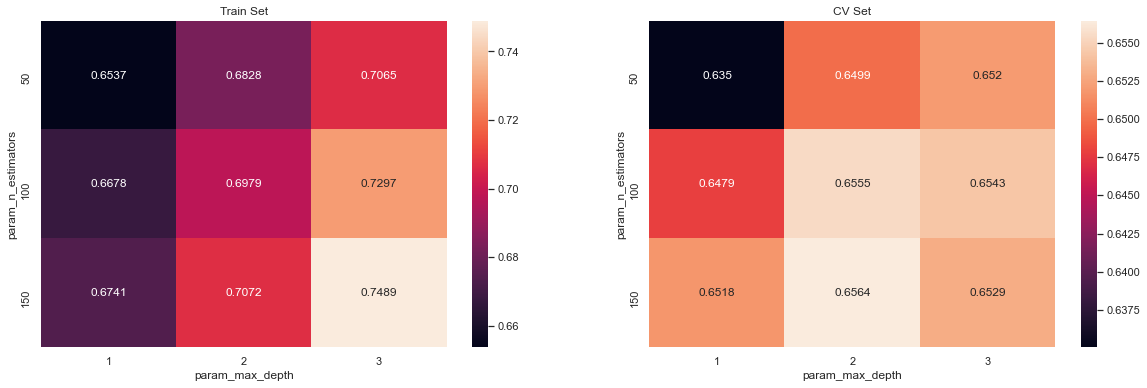

In [ ]:
import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(XGB_1.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [ ]:
print(XGB_1.best_estimator_)
print("Using the best parametrs predict the best score for Test", XGB_1.score(X_tr_1,y_train))
print("Using the best parametrs predict the best score for Test",XGB_1.score(X_te_1,y_test))

XGBClassifier(max_depth=2, n_estimators=150, scale_pos_weight=0.182)
Using the best parametrs predict the best score for Test 0.6961408918406072
Using the best parametrs predict the best score for Test 0.6877267350828524


<h2>1.8 Building XGBoost after hyperparameter tuning and show AUC_ROC curve and score</h2>

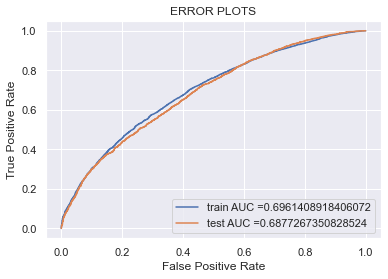

In [ ]:
# https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc
XGBC1=XGBClassifier( scale_pos_weight = 0.182, max_depth=2, n_estimators=150) #scale_pos_weight = 5.484
XGBC1.fit(X_tr_1, y_train)
y_train_pred1 = XGBC1.predict_proba(X_tr_1) [:,1]
y_test_pred1 = XGBC1.predict_proba(X_te_1) [:,1]
train_fpr1, train_tpr1, tr_thresholds1 = roc_curve(y_train, y_train_pred1)
test_fpr1, test_tpr1, te_thresholds1 = roc_curve(y_test, y_test_pred1)
plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

In [ ]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

<h2>1.9 Confusion matrix</h2>

the maximum value of tpr*(1-fpr) 0.40847738140417456 for threshold 0.496


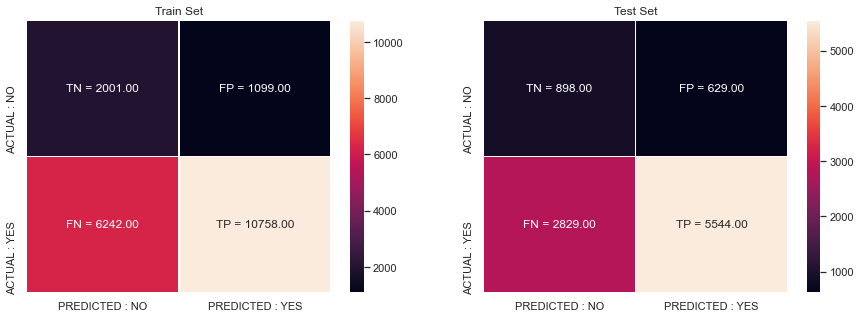

In [ ]:
#https://www.kaggle.com/agungor2/various-confusion-matrix-plots
#https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

print("="*100)
from sklearn.metrics import confusion_matrix
best_t1 = find_best_threshold(tr_thresholds1, train_fpr1, train_tpr1)
cm_train1 = confusion_matrix(y_train, predict_with_best_t(y_train_pred1, best_t1))
cm_test1 = confusion_matrix(y_test, predict_with_best_t(y_test_pred1, best_t1))
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(15,5))
labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), cm_train1.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(),
cm_test1.flatten())])).reshape(2,2)
sns.heatmap(cm_train1, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(cm_test1, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
plt.show()

# GBDT with TFIDF Response Coding

<h2>2.1 GBDT with TFIDF and response coding with categorical features</h2>

In [ ]:
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer.fit(X_train['essay'].values) # fit has to happen only on train data
vectorizer.fit(X_test['essay'].values)

# we use the fitted CountVectorizer to convert the text to vector
train_essay_tfidf = vectorizer.transform(X_train['essay'].values)
test_essay_tfidf = vectorizer.transform(X_test['essay'].values)

print("After vectorizations")
print(train_essay_tfidf.shape, y_train.shape)
print(test_essay_tfidf.shape, y_test.shape)
print("="*100)

After vectorizations
(20100, 5000) (20100,)
(9900, 5000) (9900,)


In [ ]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr_2 = hstack((train_essay_tfidf, train_data_schoolstate_feature_responseCoding, train_data_teacherprefix_feature_responseCoding.shape, train_data_gradcategory_feature_responseCoding, train_data_cleancategories_feature_responseCoding, train_data_cleansubcategories_feature_responseCoding, X1_train)).tocsr()
X_te_2 = hstack((test_essay_tfidf, test_data_schoolstate_feature_responseCoding, test_data_teacherprefix_feature_responseCoding.shape, test_data_gradcategory_feature_responseCoding, test_data_cleancategories_feature_responseCoding, test_data_cleansubcategories_feature_responseCoding, X1_test)).tocsr()

print("Final Data matrix")
print(X_tr_2.shape, y_train.shape)
print(X_te_2.shape, y_test.shape)
print("="*100)

Final Data matrix
(20100, 5016) (20100,)
(9900, 5016) (9900,)


<h2>2.2 Building model with XGBooost implementation with GridSearchCV</h2>

#### Here I have tried scale_pose_weight parameter to balanced data 

In [ ]:
# https://stackoverflow.com/questions/48377296/get-feature-importance-from-gridsearchcv
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier


XGBC_2 = XGBClassifier(scale_pos_weight = 0.182)
parameters = {'max_depth': [1, 2, 3], 'n_estimators': [50, 100, 150]}
XGB_2 = GridSearchCV(XGBC_2, parameters, cv=3, scoring='roc_auc',return_train_score=True)
set2 = XGB_2.fit(X_tr_2, y_train)

<h2>2.3 plot the performance of model both on train data and cross validation data for each hyper parameter</h2> 

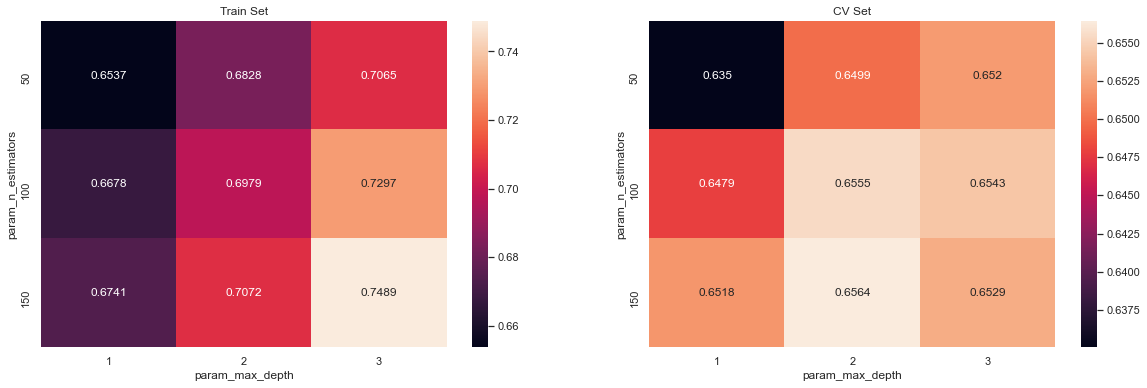

In [ ]:
import seaborn as sns; sns.set()
max_scores2 = pd.DataFrame(XGB_1.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores2.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores2.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [ ]:
print(XGB_2.best_estimator_)
print("Using the best parametrs predict the best score for Test", XGB_2.score(X_tr_2,y_train))
print("Using the best parametrs predict the best score for Test",XGB_2.score(X_te_2,y_test))

XGBClassifier(n_estimators=150, scale_pos_weight=0.182)
Using the best parametrs predict the best score for Test 0.8484181404174572
Using the best parametrs predict the best score for Test 0.7363091566266379


<h2>2.4 Building XGBoost after hyperparameter tuning and show AUC_ROC curve and score</h2>

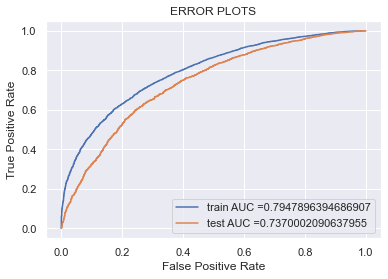

In [ ]:
# https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc
XGBC2=XGBClassifier(scale_pos_weight = 0.182, max_depth=2, n_estimators=150)
XGBC2.fit(X_tr_2, y_train)
y_train_pred2 = XGBC2.predict_proba(X_tr_2) [:,1]
y_test_pred2 = XGBC2.predict_proba(X_te_2) [:,1]
train_fpr2, train_tpr2, tr_thresholds2 = roc_curve(y_train, y_train_pred2)
test_fpr2, test_tpr2, te_thresholds2 = roc_curve(y_test, y_test_pred2)
plt.plot(train_fpr2, train_tpr2, label="train AUC ="+str(auc(train_fpr2, train_tpr2)))
plt.plot(test_fpr2, test_tpr2, label="test AUC ="+str(auc(test_fpr2, test_tpr2)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

In [ ]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

<h2>2.5 Confusion matrix</h2>

the maximum value of tpr*(1-fpr) 0.5154588235294119 for threshold 0.496


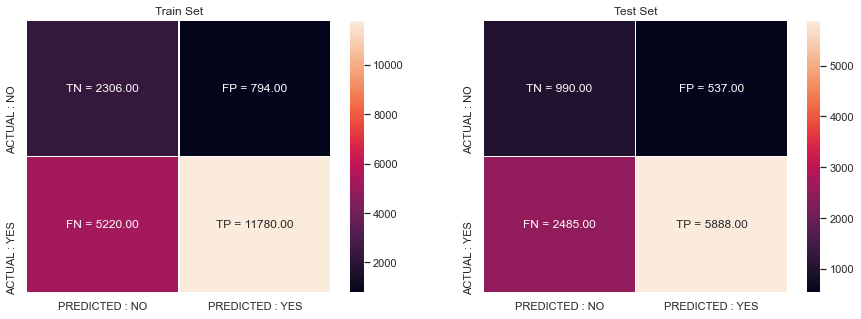

In [ ]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t2 = find_best_threshold(tr_thresholds2, train_fpr2, train_tpr2)
cm_train2 = confusion_matrix(y_train, predict_with_best_t(y_train_pred2, best_t2))
cm_test2 = confusion_matrix(y_test, predict_with_best_t(y_test_pred2, best_t2))
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(15,5))
labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), cm_train2.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(),
cm_test2.flatten())])).reshape(2,2)
sns.heatmap(cm_train2, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(cm_test2, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
plt.show()

# Final Summary with Preety Table

In [ ]:
from prettytable import PrettyTable
tb = PrettyTable()
tb.field_names= (" Vectorizer ", " Max_depth ", " n_estimators "," Test -AUC " ,)
tb.add_row([" TFIDF W2V with Response Coding ", 2, 150, 0.687]) #'max_depth': [1, 2, 3], 'n_estimators': [50, 100, 150]
tb.add_row([" TF IDF with Response Coding", 2, 150, 0.737 ])

print(tb.get_string(titles = "XGBoost - Observations"))

+----------------------------------+-------------+----------------+-------------+
|            Vectorizer            |  Max_depth  |  n_estimators  |  Test -AUC  |
+----------------------------------+-------------+----------------+-------------+
|  TFIDF W2V with Response Coding  |      2      |      150       |    0.687    |
|    TF IDF with Response Coding   |      2      |      150       |    0.737    |
+----------------------------------+-------------+----------------+-------------+
